In [2]:
import functions
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from hosd_python.hosd import apply_hosd # library that I converted from MATLAB

In [3]:
components = np.load('patient_ICA/P044_S01_R001_ICA.npy')
print(components.shape)

(292592, 18)


In [8]:
no_ica_chans = 18
fs=1000
span = 10*fs
offset = 100*fs 
ms2s = lambda x, _:f'{x/1000:g}' 
window_size=int(1400) # used for higher-order-spectral filtering
time_axis=np.linspace(0,int(window_size)-1,num=int(window_size))

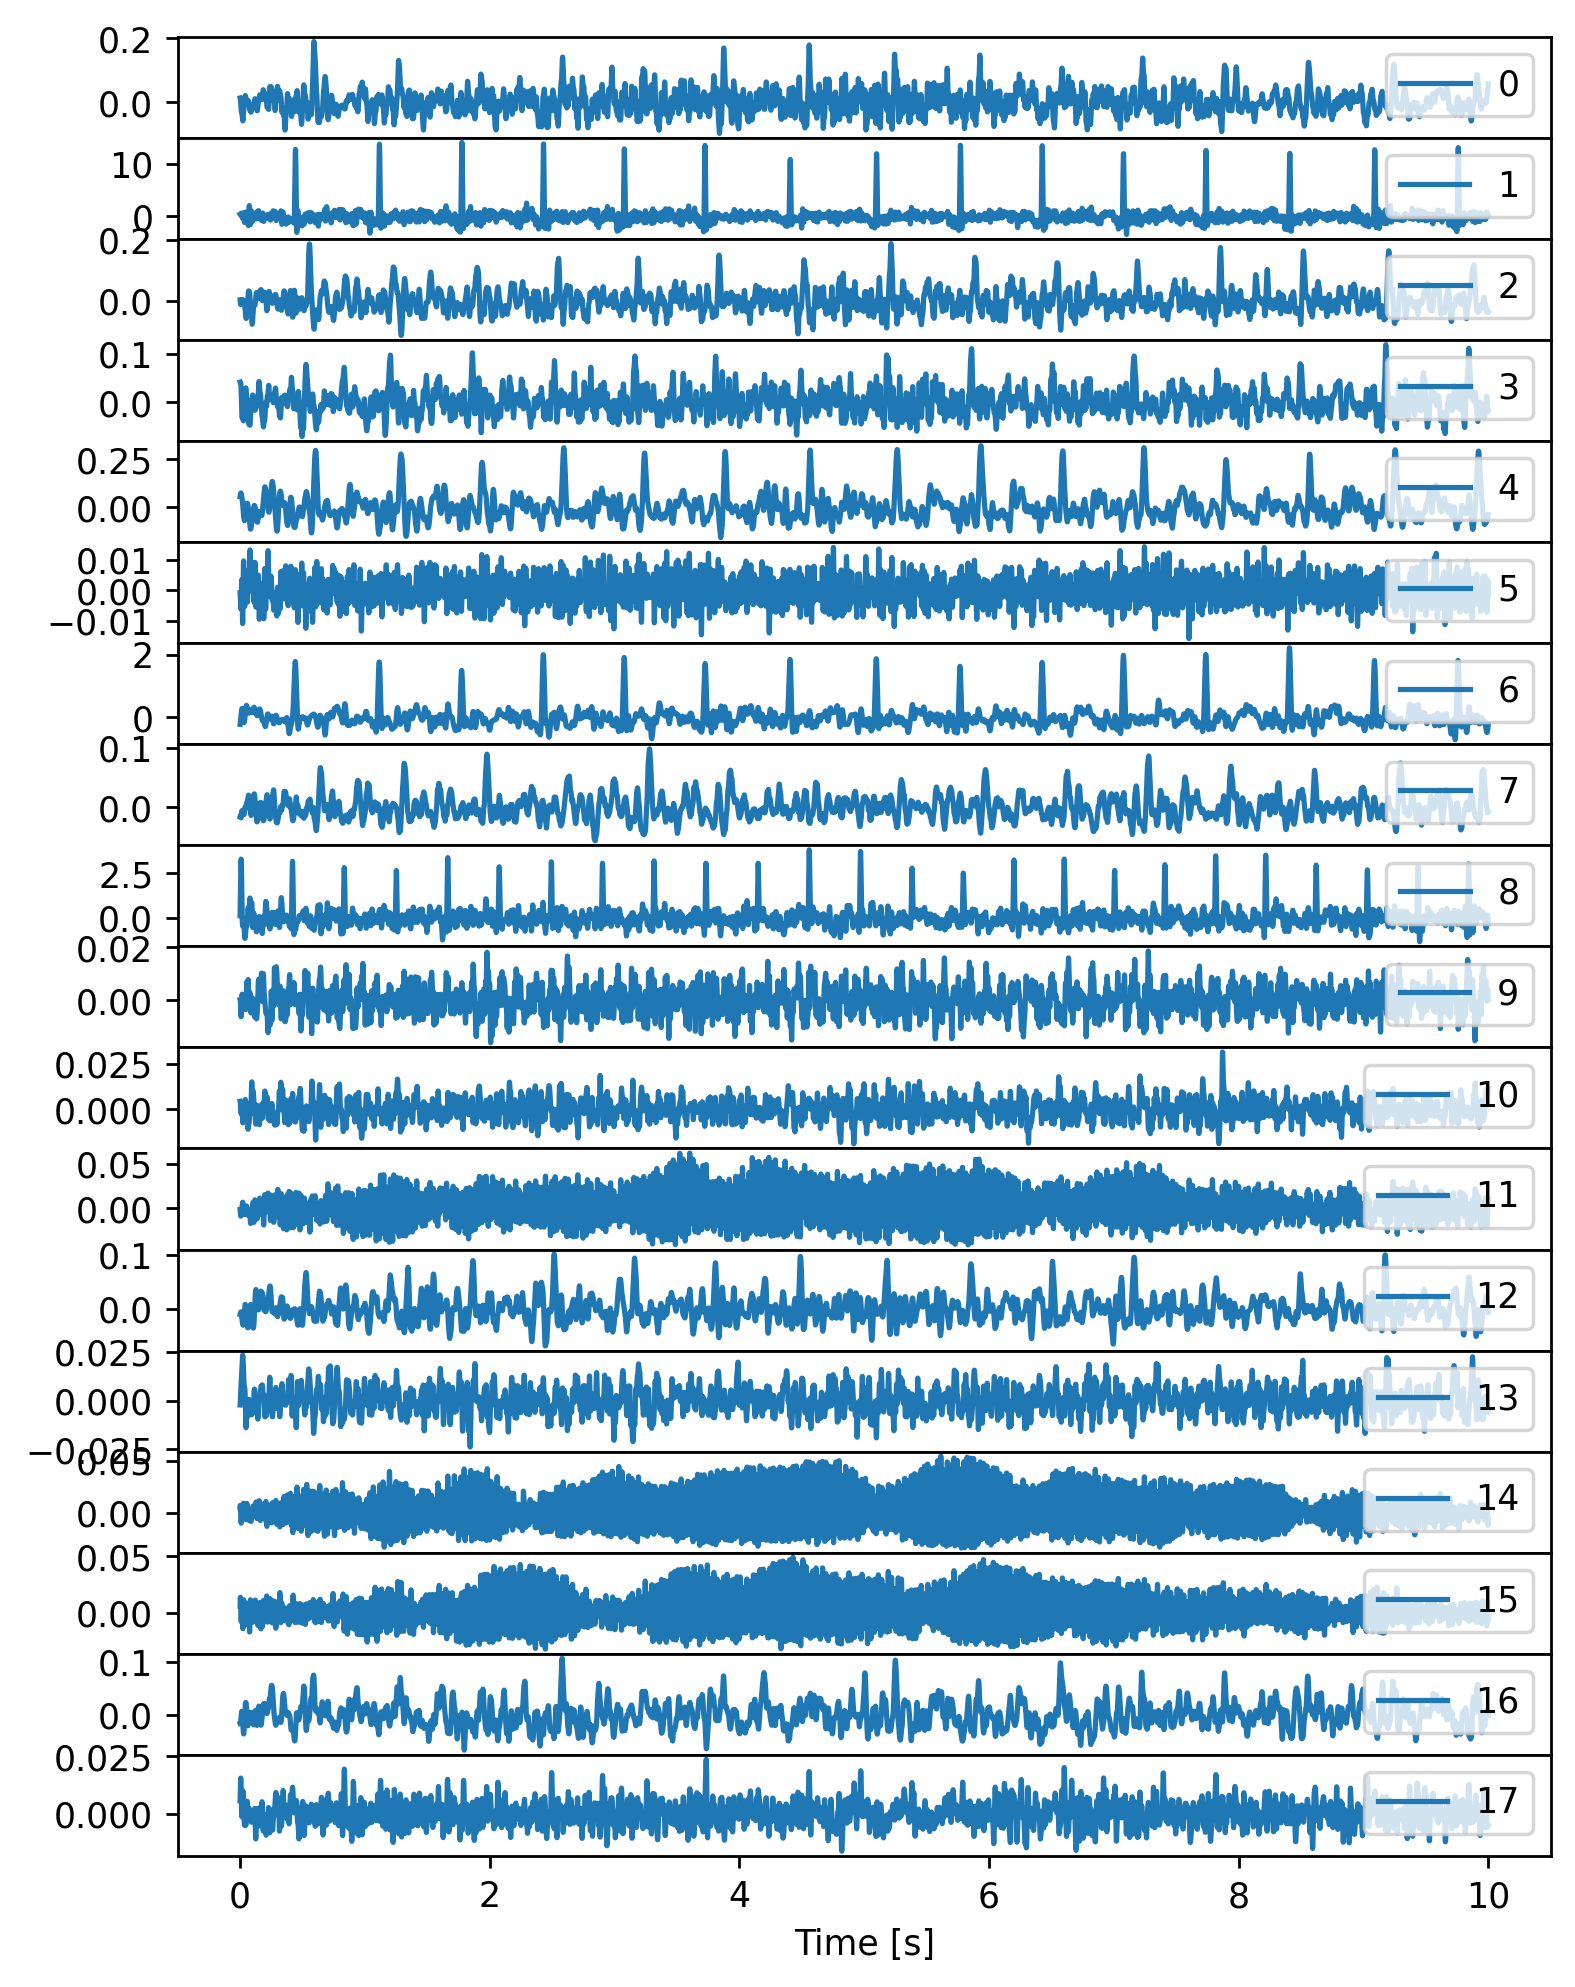

In [9]:
components_hos = np.zeros_like(components)
for channel in range(components_hos.shape[1]):
    beat, detect = apply_hosd(components[:,channel], window_size) 
    components_hos[:,channel] = detect

fig, ax = plt.subplots(no_ica_chans, 1, sharex=True, figsize=(18 / 2.54, 24 / 2.54), dpi=250) #
fig.subplots_adjust(hspace=0)
    
for j in range(no_ica_chans):
    ax[j].plot(components_hos[offset:(offset + span), j], label=str(j))
    ax[j].legend(loc=1)
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')
plt.show()

### Clearly the component 8 is the fetal component, let's analyze more

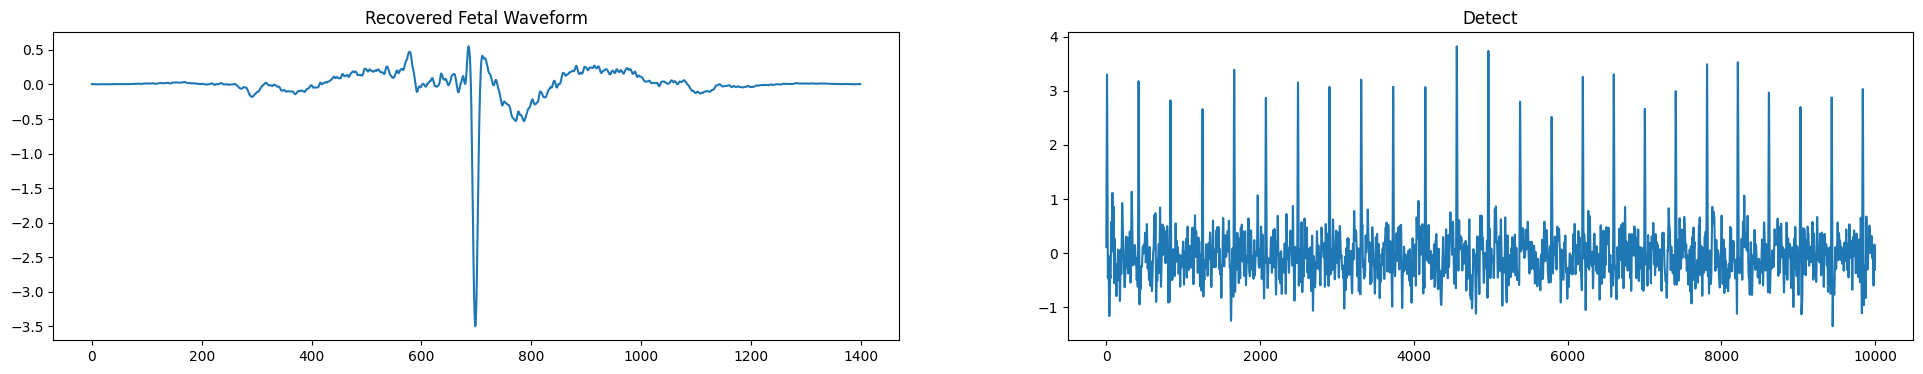

<Figure size 640x480 with 0 Axes>

In [25]:
beat, detect = apply_hosd(components[:,8], window_size) 
fig, axs = plt.subplots(1, 2, figsize=(24, 4))
axs[0].plot(beat)
axs[0].set_title('Recovered Fetal Waveform')
axs[1].plot(detect[offset:(offset + span)])
axs[1].set_title('Detect')
plt.show()
plt.tight_layout()

### Let's start with what detect_beats do?
detect_beats take the 1D input array detect (size: num_samples) and returns some properties of the input data
1. it creates the histogram of the input data for 40 bins --> y (size 40), bins
    - y  is the heights of bins and bins are the points of the bins
2. takes the center points of the bins --> x
3. tries to fit a  standart gaussian to this histogram with initial parameters np.max(y), 0, 1 --> popt, pcov
    - popt : optimal parameters, amplitude, mean, std
    - pcov : estimated covarience matrix
4. then uses find_peaks, to find the peak positions and peak heights and again uses an histogram for this.
5. Then fits a gaus to this histogram and gets the optimal parameters

**Returns**:
- RR mean of secondly fitted gaus
- sigma_RR is std
- peaks are the first peaks
- popt is the parameters of the fitted gaus
- yy: heights of bins, and xx is the centers of the bins

### A Savitzky-Golay filter is a type of digital filter that smooths the data while preserving its shape and features, such as peaks and valleys.
- 41 is the length of the window and 3 is the order of the used polynomial

### Then it finds the indeces of peaks that satisfy a certain criteria that will be used for averaging

### avg_based_QRScomplex takes the window sized peaks and average all of them since this corresponds to waveform operation of HOS, it can be seen that they match on top of each other, red line illustrates the manually calculated means from detects and the red is the returned average by HOS function


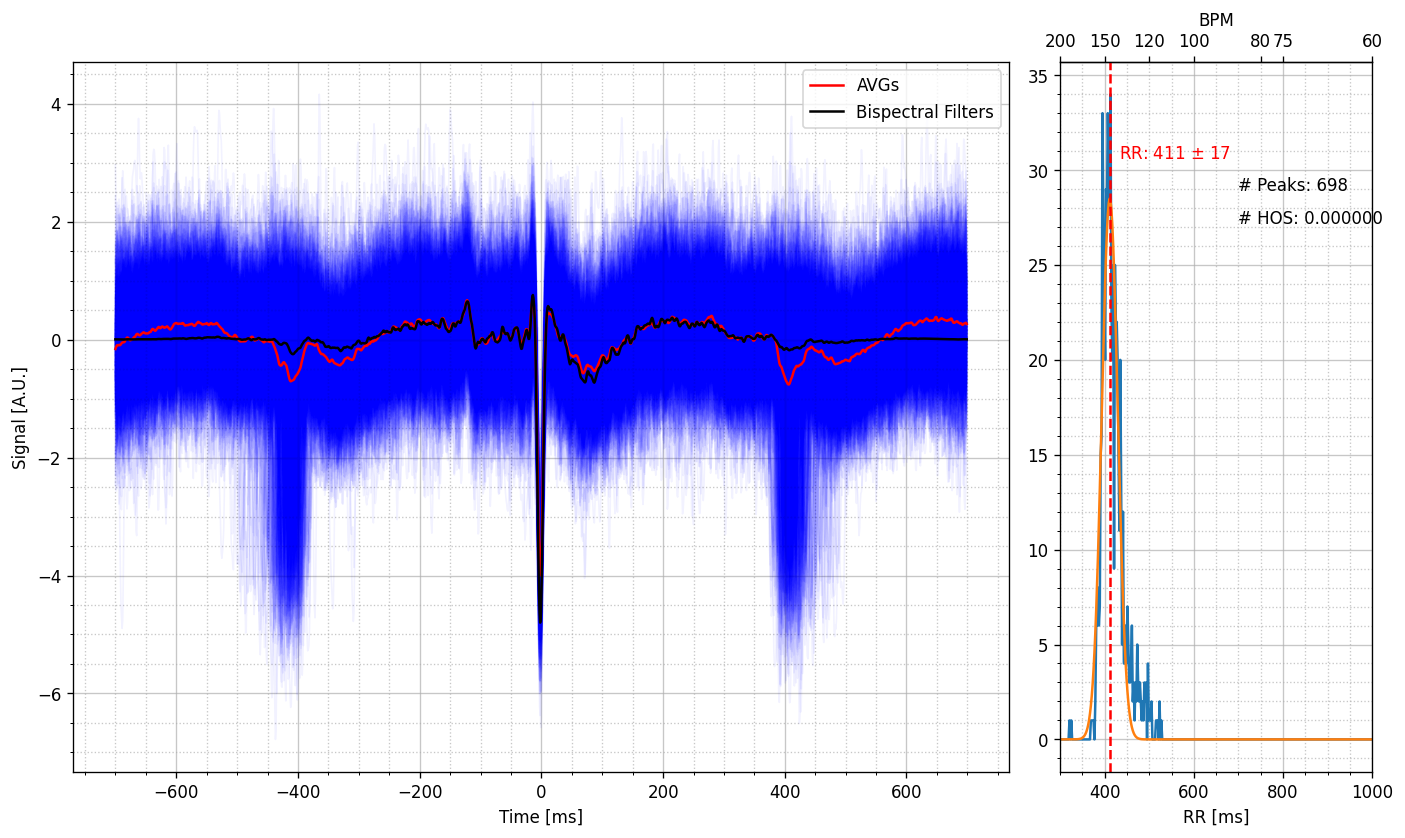

In [30]:
RR, sigma_RR, peaks, popt_RRs, yy, xx = functions.detect_beats(detect)
try:
    savgol_median = savgol_filter(np.diff(peaks), 41, 3)
    avg_peaks_list = peaks[np.where(np.square((np.diff(peaks) - savgol_median) / sigma_RR) < 2)]
except:
    avg_peaks_list = peaks

peaks = avg_peaks_list
if len(peaks)<3:
    print('skipped (low peak count)')
else:
    slice_box, avg_mean,worked = functions.avg_based_QRScomplex(components[:,8], peaks,sigma_RR, box_size=window_size)
    segmentation_data=functions.waveform_plot(np.array(slice_box), time_axis-window_size/2, add_lines=[avg_mean,beat], sideplot=[xx,yy,popt_RRs,RR,sigma_RR,0])